### 数値微分を用いたニュートン法や勾配降下法は微分演算精度が低いので，なるべく解析微分式を用いる

$f'(\boldsymbol{x})= \lim_{h \to 0} \ \frac{f(\boldsymbol{x}-h) - f(\boldsymbol{x})}{h}$で導関数を求めると，微分定義の分子$f(\boldsymbol{x}-h) - f(\boldsymbol{x})$で桁落ちするので，精度が低い微分値を算出してしまう。

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg

### ニュートン法用の数値微分

In [11]:
def newton_numerical_gradient(F, X):
    h = 1e-4 # 微小値 0.0001(10^-4)
    xshape = None
    xsize = None
    fsize = F(X).size
        
    # 変数ベクトルxを[Nx1]形状に変更
    if (X.ndim != 1):
        xshape = X.shape
        X = X.reshape(1, -1)
    xsize = X.size
        
    yacobi_grad = [] # ヤコビ行列 行数：関数の種類，列数：変数の種類
    
    # 各関数・変数で数値微分を行う
    for j in range(xsize):
            
        # 微小値hの追加前の変数x
        tmp_x = X[j]
            
        # f(x+h)の計算
        X[j] = tmp_x + h # 微分する変数だけ，微小値を加算
        fxh1 = F(X)
        #print("fxh1", fxh1)
            
        # f(x-h)の計算
        X[j] = tmp_x - h # 微分する変数だけ，微小値を減算
        fxh2 = F(X)
        #print("fxh2", fxh2)
            
        grad = (fxh1 - fxh2) / (2*h) # 中央差分
        #print("grad", grad)
        yacobi_grad.append(grad) # 列ベクトル単位で格納
        
        X[j] = tmp_x
    
    #print(yacobi_grad)
    #print(np.r_[yacobi_grad])
    yacobi_grad = np.r_[yacobi_grad].T
    #print("yacobi_grad", yacobi_grad)
    
    # 変数ベクトルXを元の形状に戻す
    X = X.reshape(xshape)
    
    return yacobi_grad

ニュートン法の目的関数
$$
\begin{cases}
f_1(x,y) = x^3 - 2\\
f_2(x,y) = x^2 + y^2 - 1
\end{cases}
$$

In [12]:
# ニュートン法の対象関数ベクトル
def f1(x,y):
    return x**3 - 2*y

def f2(x,y):
    return x**2 + y**2 - 1

def targetF(xx):
    x = xx[0]
    y = xx[1]
    return np.array([f1(x,y), f2(x,y)])

$$
f(\boldsymbol{x}) = 
\begin{pmatrix}
f_1(\boldsymbol{x}) \\
f_2(\boldsymbol{x})
\end{pmatrix}
\quad
f(\boldsymbol{x}) = 
\begin{pmatrix}
1 \\
1
\end{pmatrix}
\begin{pmatrix}
-1 \\
-1
\end{pmatrix}
\begin{pmatrix}
1 \\
-1
\end{pmatrix}
$$
についてヤコビ行列を求める

In [13]:
# 微分対象のXベクトル
targetX = [np.array([1,1]), np.array([-1,-1]), np.array([1,-1]), np.array([0.1, -0.1])]

for tx in targetX:
    print(newton_numerical_gradient(targetF, tx))

[[  5000. -10000.]
 [  5000.   5000.]]
[[  5000. -10000.]
 [ -5000.  -5000.]]
[[  5000. -10000.]
 [  5000.  -5000.]]
[[ 0.03000001 -2.        ]
 [ 0.2        -0.2       ]]


### 数値微分を用いたニュートン法

In [14]:
class NumerialGradientNewton:
    def __init__(self, f, eps=1e-10, max_iter=1000):
        self.f_ = f
        self.eps_ = eps
        self.max_iter_ = max_iter
        self.path_ = None
        
    def solve(self, x0):
        x = x0
        iter = 0
        self.path_ = x0.reshape(1, -1)
        while True:
            numerical_yacobi = newton_numerical_gradient(self.f_, x0)
            
            x_new = x - np.dot(linalg.inv(numerical_yacobi), self.f_(x)) # ヤコビ行列 self.df_(x)
            self.path_ = np.r_[self.path_, x_new.reshape(1, -1)]
            
            # 収束条件
            if ((x - x_new)**2).sum() <= self.eps_ * self.eps_:
                break
            
            x = x_new
            iter += 1
            if iter == self.max_iter_:
                break
                
        return x_new

/Users/inoueshinichi/opt/anaconda3/envs/PytorchPy36/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'label'
  # Remove the CWD from sys.path while we load stuff.
/Users/inoueshinichi/opt/anaconda3/envs/PytorchPy36/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'label'
  # This is added back by InteractiveShellApp.init_path()


[0.92381137 0.44614416]
[-0.92381137 -0.44614416]
[0.88185867 0.38717473]


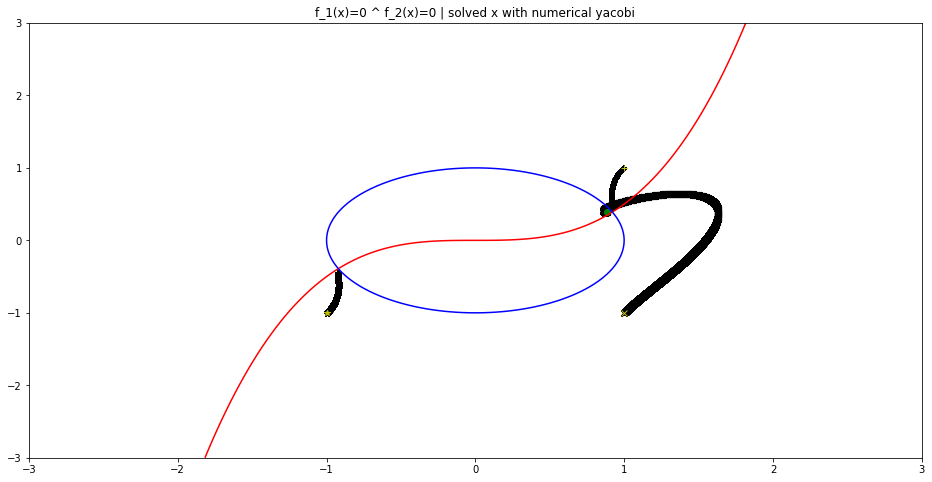

In [15]:
xmin, xmax, ymin, ymax = -3, 3, -3, 3
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
x = np.linspace(xmin, xmax, 200)
y = np.linspace(ymin, ymax, 200)
xmesh, ymesh = np.meshgrid(x, y)
z1 = f1(xmesh, ymesh)
z2 = f2(xmesh, ymesh)
ax.contour(xmesh, ymesh, z1, colors="r", levels=[0], label="f_1(x)=0")
ax.contour(xmesh, ymesh, z2, colors="b", levels=[0], label="f_2(x)=0")

solver = NumerialGradientNewton(targetF,max_iter=12000) # Numerial Gradient Newton
initials = [np.array([1,1]),
           np.array([-1,-1]),
           np.array([1,-1])]

markers = ["+", "*", "x"]

sols = []
for x0, m in zip(initials, markers):
    sol = solver.solve(x0)
    ax.scatter(solver.path_[:, 0], solver.path_[:, 1], color="k", marker=m)
    sols.append(sol)
    print(sol)
    
# 初期値
for init_x, m in zip(initials, markers):
    ax.plot(init_x[0], init_x[1], color="y", marker=m)
    

# 数値計算解
ax.scatter(sols[-1][0], sols[-1][1], color="g")

ax.set_title("f_1(x)=0 ^ f_2(x)=0 | solved x with numerical yacobi")


plt.show()

解析微分によるニュートン法の最適解
<img src="数理最適化_data/解析微分によるニュートン法の最適解.png">

### 勾配降下法用の数値微分

$5x^2 - 6xy + 3y^2 + 6x - 6y$

In [16]:
def numerical_gradient(f, x):
    h = 1e-4 # 微小値 0.0001(10^-4)
    xshape = None
    
    if (x.ndim != 1):
        xshape = x.shape
        x = x.reshape(1, -1)
        x = x[0]

    grad = np.zeros_like(x) # xと同じ形状
    
    # 関数fに対して偏微分を行い，多次元配列を生成
    for i in range(x.size):
        
        # 微小値hの追加前の変数x
        tmp_x = x[i]
        
        # f(x+h)の計算
        x[i] = tmp_x + h # 微分する変数だけ，微小値を加算
        fxh1 = f(x)
        #print("fxh1", fxh1)
        
        # f(x-h)の計算
        x[i] = tmp_x - h # 微分する変数だけ，微小値を減算
        fxh2 = f(x)
        #print("fxh2", fxh2)
        
        grad[i] = (fxh1 - fxh2) / (2*h)
        #print("grad", grad)
        
        x[i] = tmp_x # 値を元に戻す
        
    grad = grad.reshape(xshape)
        
    return grad

In [17]:
class NumericalGradientDescent:
    def __init__(self, f, alpha=0.01, eps=1e-6):
        self.f_= f
        self.alpha_= alpha
        self.eps_= eps
        self.path_= None
        
    def solve(self, init):
        x = init
        path = []
        grad = numerical_gradient(f, x) # 数値微分
        path.append(x)
        
        while (grad**2).sum() > self.eps_**2:
            grad = numerical_gradient(f, x) # 数値微分
            x = x - self.alpha_ * grad
            path.append(x)
            
        self.path_ = np.array(path)
        self.x_ = x
        self.opt_ = self.f_(x)

In [18]:
# 目的関数
def f(xx):
    x = xx[0]
    y = xx[1]
    return 5 * x ** 2 - 6 * x * y + 3 * y ** 2 + 6 * x - 6 * y

In [19]:
Nalgo = NumericalGradientDescent(f)
initial = np.array([1, 0.5]) # [1.0, 1.0]だと勾配がオーバーフローして，収束条件で引っかからずにスルーされる
Nalgo.solve(initial)
print(Nalgo.x_)
print(Nalgo.opt_)

[3.39766858e-07 1.00000047e+00]
-2.9999999999997167


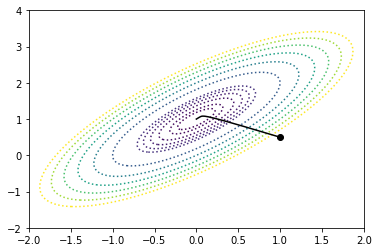

In [20]:
fig, ax = plt.subplots()
ax.scatter(initial[0], initial[1], color="k", marker="o")
ax.plot(Nalgo.path_[:, 0], Nalgo.path_[:, 1], color="k", linewidth=1.5)

xs = np.linspace(-2, 2, 300)
ys = np.linspace(-2, 4, 400)
xmesh, ymesh = np.meshgrid(xs, ys)
xx = np.r_[xmesh.reshape(1, -1), ymesh.reshape(1, -1)]
levels = [-3, -2.9, -2.8, -2.6, -2.4, -2.2, -2, -1, 0, 1, 2, 3, 4]
ax.contour(xs, ys, f(xx).reshape(xmesh.shape), levels=levels, linestyles="dotted")

ax.set_ylim([-2, 4])
ax.set_xlim([-2, 2])
plt.show()

解析微分による勾配降下法の最適解  
<img src="数理最適化_data/解析微分による勾配降下法の最適解.png">
グラフ  
<img src="数理最適化_data/解析微分による勾配降下法の最適解_グラフ.png">